## K-Means

- Convert categorical data
- Scale the data: Since K-Means is sensitive to the scale of the data we can use StandardScaler or MinMaxScaler

In [1]:
# all necessary imports

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import requests
import time
import wandb

from tqdm import tqdm
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_score

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data = pd.read_csv("/content/drive/MyDrive/ml_project/prozorro_full.csv")
data = data.drop(columns=['expected_value_category'])

In [ ]:
train_data, temp_data = train_test_split(data, test_size=0.1, random_state=42, shuffle=True)
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42, shuffle=True)

print(f"Train: {len(train_data)} rows")
print(f"Validation: {len(val_data)} rows")
print(f"Test: {len(test_data)} rows")

Train: 2354317 rows
Validation: 130795 rows
Test: 130796 rows


In [2]:
# train_data.to_csv("train.csv", index=False)
# val_data.to_csv("val.csv", index=False)
# test_data.to_csv("test.csv", index=False)

train_data = pd.read_csv("/content/train.csv")
val_data = pd.read_csv("/content/val.csv")
test_data = pd.read_csv("/content/test.csv")

In [3]:
numerical_cols = ['expected_value', 'price_per_unit', 'number_of_participants',
                      'number_of_disqualifications', 'number_of_questions', 'number_of_requirements',
                      'number_of_complaints', 'number_of_monitorings']
categorical_cols = ['procurement_procedure', 'VAT', 'procedure_status', 'tender_status']

def prepare_data(data, encoder=None, scaler=None, fit=False):
    if fit:
        encoder = OneHotEncoder(drop='first', sparse_output=False)
        encoded_cols = encoder.fit_transform(data[categorical_cols])
    else:
        encoded_cols = encoder.transform(data[categorical_cols])

    encoded_df = pd.DataFrame(encoded_cols, columns=encoder.get_feature_names_out(categorical_cols))

    result = data.drop(columns=categorical_cols).reset_index(drop=True)
    result = pd.concat([result, encoded_df], axis=1)

    if fit:
        scaler = StandardScaler()
        result[numerical_cols] = scaler.fit_transform(result[numerical_cols])
    else:
        result[numerical_cols] = scaler.transform(result[numerical_cols])

    return result, encoded_df, encoder, scaler


In [4]:
# Training phase — fit encoder and scaler
train_prepared, _, encoder, scaler = prepare_data(train_data, fit=True)

# Validation and test phase — reuse encoder and scaler
val_prepared, _, _, _ = prepare_data(val_data, encoder=encoder, scaler=scaler)
test_prepared, _, _, _ = prepare_data(test_data, encoder=encoder, scaler=scaler)

final_cols = numerical_cols + list(encoder.get_feature_names_out(categorical_cols))

In [ ]:
kmeans = KMeans(n_clusters=2)
kmeans.fit(train_prepared[final_cols])

KMeans(n_clusters=2)

In [ ]:
def apply_kmeans(prepared_df, model, final_cols, threshold=None):
    distances = model.transform(prepared_df[final_cols])
    prepared_df['Cluster'] = model.predict(prepared_df[final_cols])
    prepared_df['Distance_to_centroid'] = distances.min(axis=1)

    if threshold is not None:
        prepared_df['Anomaly'] = prepared_df['Distance_to_centroid'] > threshold
    return prepared_df

train_prepared = apply_kmeans(train_prepared, kmeans, final_cols)
threshold = train_prepared['Distance_to_centroid'].quantile(0.95)
train_prepared['Anomaly'] = train_prepared['Distance_to_centroid'] > threshold

In [ ]:
def tune_kmeans_by_silhouette(train_data, val_data, final_cols, cluster_range, threshold_range, plot=True):
    silhouette_scores = []
    threshold_map = {}

    best_score = -1
    best_k = None
    best_model = None
    best_threshold = None
    best_quantile = None

    for k in tqdm(cluster_range, desc="Clustering"):
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(train_data[final_cols])

        val_clusters = kmeans.predict(val_data[final_cols])
        score = silhouette_score(val_data[final_cols], val_clusters)
        silhouette_scores.append(score)

        if score > best_score:
            best_score = score
            best_k = k
            best_model = kmeans

        # Compute distance-based anomaly thresholds for this model
        distances = kmeans.transform(val_data[final_cols])
        val_distance_to_centroid = distances.min(axis=1)

        threshold_map[k] = []
        for q in threshold_range:
            threshold = np.quantile(val_distance_to_centroid, q)
            anomaly_count = np.sum(val_distance_to_centroid > threshold)
            threshold_map[k].append(anomaly_count)

    distances = best_model.transform(val_data[final_cols])
    val_distance_to_centroid = distances.min(axis=1)

    for q in threshold_range:
        threshold = np.quantile(val_distance_to_centroid, q)
        count = np.sum(val_distance_to_centroid > threshold)
        if 0 < count < len(val_data):
            best_threshold = threshold
            best_quantile = q
            break

    if plot:
        fig, axs = plt.subplots(2, 1, figsize=(15, 7), sharex=False)

        # Top plot: Silhouette Score vs n_clusters
        axs[0].plot(cluster_range, silhouette_scores, color='#1ecbe1')
        axs[0].set_title("Silhouette Score vs n_clusters")
        axs[0].set_xlabel("n_clusters")
        axs[0].set_ylabel("Silhouette Score")

        # Bottom plot: Anomaly count vs Threshold Quantile for each k
        for k in cluster_range:
            axs[1].plot(threshold_range, threshold_map[k], label=f"k={k}")
        axs[1].set_title("Anomaly Count vs Threshold Quantile")
        axs[1].set_xlabel("Threshold Quantile")
        axs[1].set_ylabel("Number of Anomalies")
        axs[1].legend()

        plt.tight_layout()
        plt.show()

    return best_model, best_k, best_threshold, best_score, best_quantile


Clustering: 100%|██████████| 8/8 [35:08<00:00, 263.62s/it]


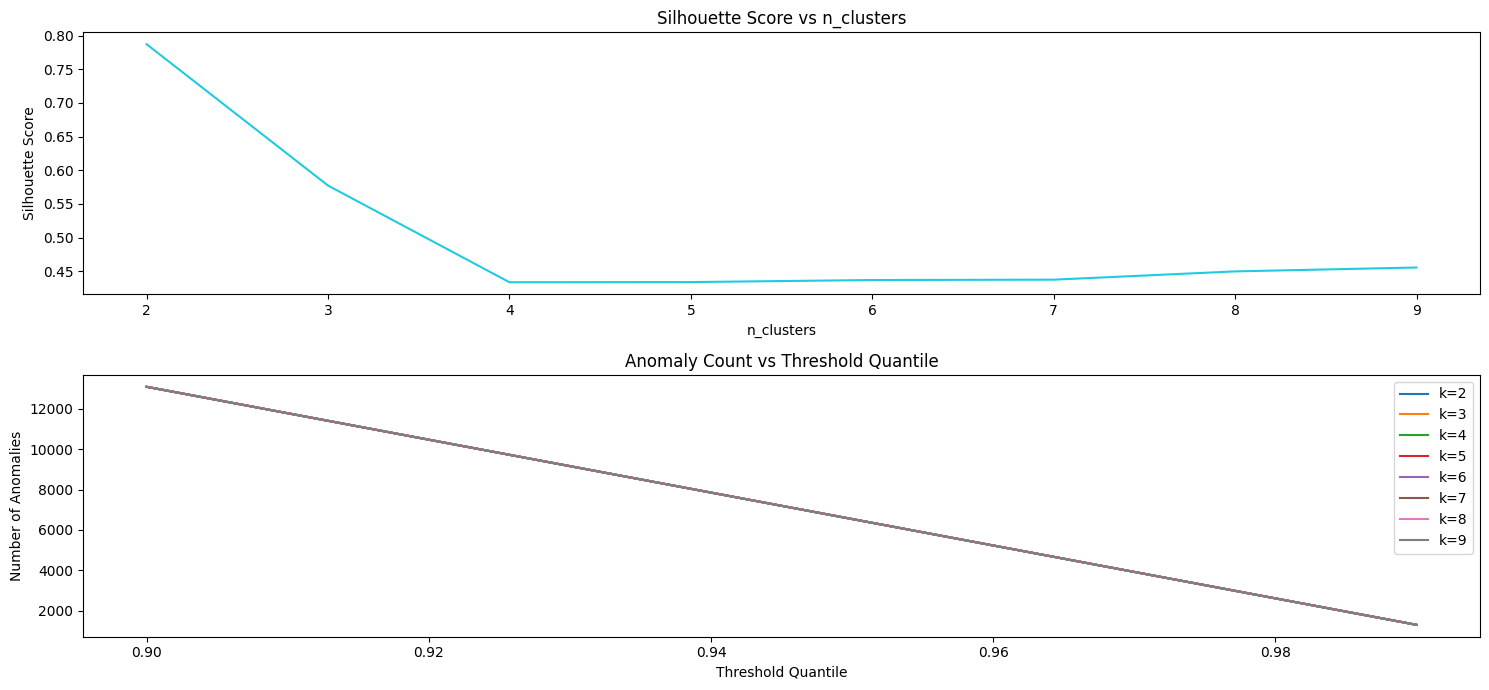

Best n_clusters: 2, silhouette score: 0.7871
Selected quantile: 0.9, which corresponds to threshold distance: 2.7135


In [ ]:
final_cols = numerical_cols + list(encoder.get_feature_names_out(categorical_cols))

cluster_range = range(2, 10)
threshold_range = np.linspace(0.90, 0.99, 10)

best_kmeans, best_k, best_threshold, best_silhouette, best_quantile = tune_kmeans_by_silhouette(
    train_prepared, val_prepared, final_cols, cluster_range, threshold_range
)

print(f"Best n_clusters: {best_k}, silhouette score: {best_silhouette:.4f}")
print(f"Selected quantile: {best_quantile}, which corresponds to threshold distance: {best_threshold:.4f}")

In [ ]:
test_distances = best_kmeans.transform(test_prepared[final_cols])
test_prepared['Distance_to_centroid'] = test_distances.min(axis=1)
test_prepared['Anomaly'] = test_prepared['Distance_to_centroid'] > best_threshold

test_clusters = best_kmeans.predict(test_prepared[final_cols])
test_silhouette = silhouette_score(test_prepared[final_cols], test_clusters)
print(f"Test silhouette score: {test_silhouette:.4f}")

Test silhouette score: 0.7982


In [ ]:
anomalies = test_prepared[test_prepared['Anomaly'] == True]

In [ ]:
anomalies.head()

,tender_id,tender,expected_value,announcement_date,organizer,winner,duration,price_per_unit,measurement,cpv_classification,...,procedure_status_Очікування пропозицій,procedure_status_Прекваліфікація,procedure_status_Прекваліфікація (період оскаржень),procedure_status_Пропозиції розглянуто,tender_status_Завершено лот закупівлі,tender_status_Неуспішний лот закупівлі,tender_status_Скасовано лот закупівлі,procedure_type,Distance_to_centroid,Anomaly
12,UA-2020-06-01-008057-b-L1,ДСТУ Б.Д.1.1.-1:2013 Реконструкція адмінбудівл...,-0.007963,2020-06-01,Головне управління Національної поліції в Зака...,Фізична особа-підприємець Влад Георгій Михайло...,25,-0.004110,робота,45454000-4 Реконструкція,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,Спрощена процедура закупівлі,4.464041,True
15,UA-2019-06-07-000817-a-L1,Прилади звукової та візуальної сигналізації,0.052375,2019-06-07,Маріупольський міжрайонний відділ Управління п...,"ТОВ ""НАУКОВО-ВИРОБНИЧЕ ПІДПРИЄМСТВО ""КРОНОС"" |...",-,-0.034349,-,31620000-8 Прилади звукової та візуальної сигн...,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,Відкриті торги з особливостями,5.448494,True
24,UA-2023-11-23-005012-a-L1,Швидкий тест на 3 наркотики (MDPV1000/α-PVP100...,-0.040361,2023-11-23 00:00:00,"Комунальне некомерційне підприємство ""Сахновщи...",ФОП Дудченко Андрій Олександрович | 3492001892,13,-0.032813,-,33120000-7 Системи реєстрації медичної інформа...,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,Запит ціни пропозиції,3.356226,True
31,UA-2017-03-03-000375-a-L1,Лот №1 ДК 021:2015- 15112130-6-«Курятина» (філ...,-0.039757,2017-03-03,"МЕДИЧНИЙ РЕАБІЛІТАЦІЙНИЙ ЦЕНТР ""ОДЕСЬКИЙ"" | 24...",ФОП Болдирєва Н.І. | 1514900027,40,-0.035220,кілограм,15112130-6 Курятина,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,Відкриті торги з особливостями,2.911212,True
47,UA-2021-12-29-004656-b-L1,«Здійснення технічного нагляду по об’єкту буді...,-0.015958,2021-12-29 00:00:00,Луцький національний технічний університет | 0...,"ФОП ""Токарчук Юрій Богданович"" | 3079923293",37,-0.026235,робота,71520000-9 Послуги з нагляду за виконанням буд...,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,Спрощена процедура закупівлі,2.856641,True


### Results analysis

In [ ]:
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(test_prepared[final_cols])

test_prepared['TSNE1'] = X_tsne[:, 0]
test_prepared['TSNE2'] = X_tsne[:, 1]

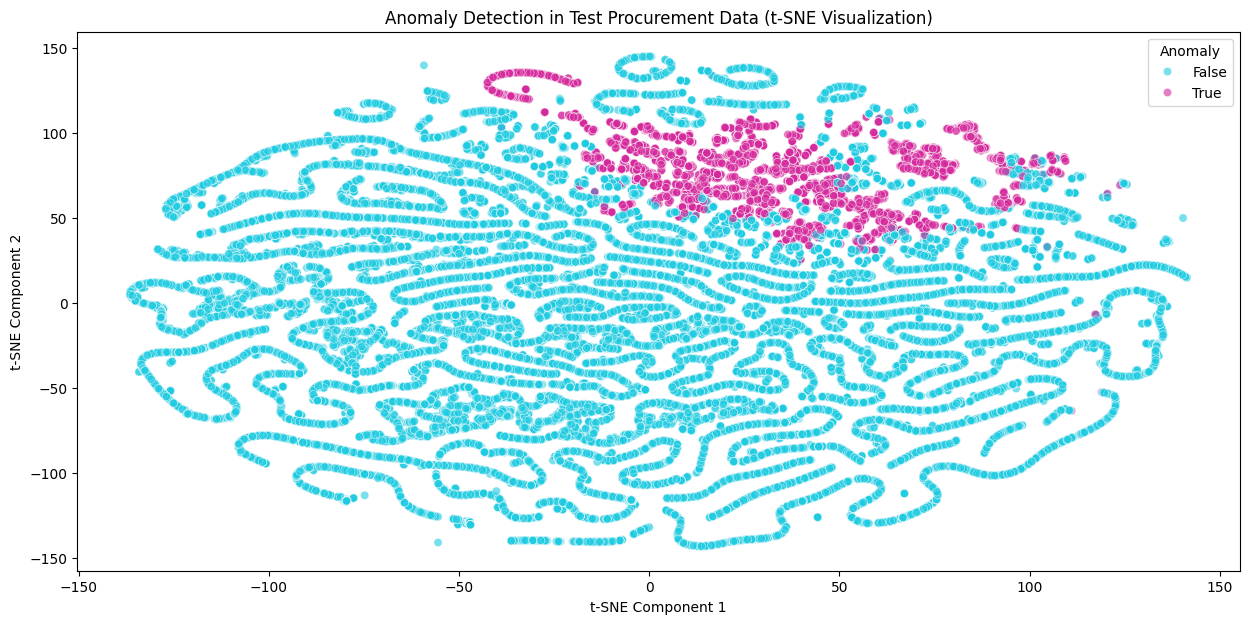

In [ ]:
plt.figure(figsize=(15, 7))
sns.scatterplot(data=test_prepared, x='TSNE1', y='TSNE2', hue='Anomaly', palette={True: '#d52a9d', False: '#1ecbe1'}, alpha=0.6)
plt.title("Anomaly Detection in Test Procurement Data (t-SNE Visualization)")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend(title="Anomaly")
plt.show()

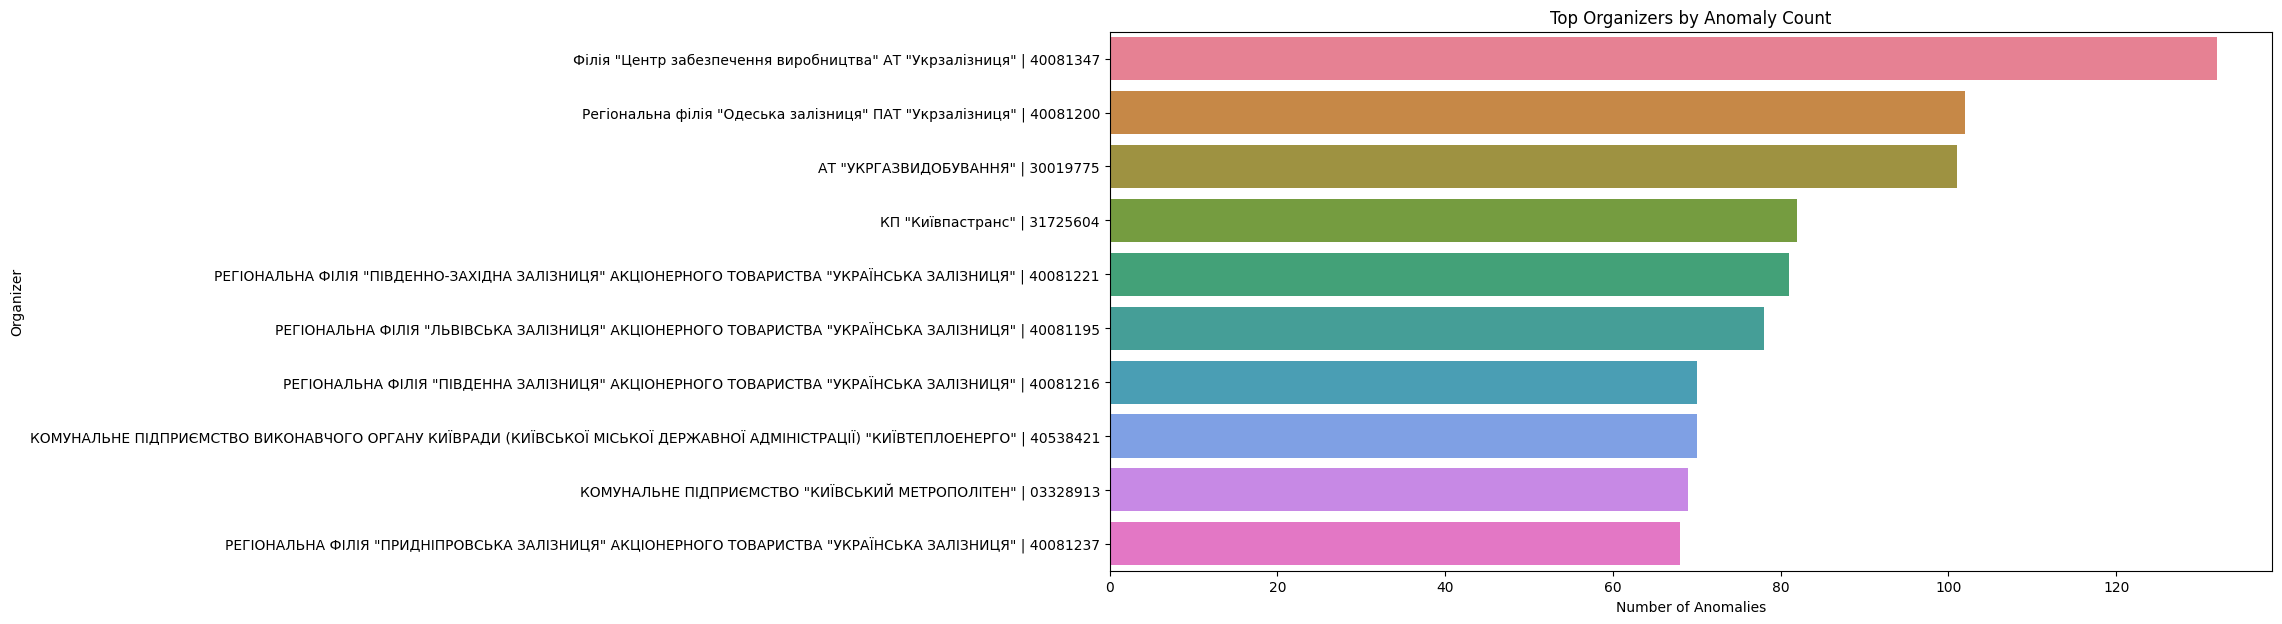

In [ ]:
top_orgs = anomalies['organizer'].value_counts().nlargest(10)
top_orgs_df = top_orgs.reset_index()
top_orgs_df.columns = ['Organizer', 'Anomaly Count']

plt.figure(figsize=(15, 7))
sns.barplot(data=top_orgs_df, x='Anomaly Count', y='Organizer',
            hue='Organizer', palette='husl', legend=False)
plt.title("Top Organizers by Anomaly Count")
plt.xlabel("Number of Anomalies")
plt.ylabel("Organizer")
plt.show()

In [ ]:
procurement_cols = [col for col in test_prepared.columns if col.startswith('procurement_procedure_')]

test_prepared['procedure_type'] = test_prepared[procurement_cols].idxmax(axis=1)
test_prepared['procedure_type'] = test_prepared['procedure_type'].str.replace('procurement_procedure_', '', regex=False)

procurement_summary = test_prepared.groupby('procedure_type')['Anomaly'].agg(['count', 'sum'])
procurement_summary['anomaly_ratio'] = procurement_summary['sum'] / procurement_summary['count']
procurement_summary = procurement_summary.sort_values('sum', ascending=False)

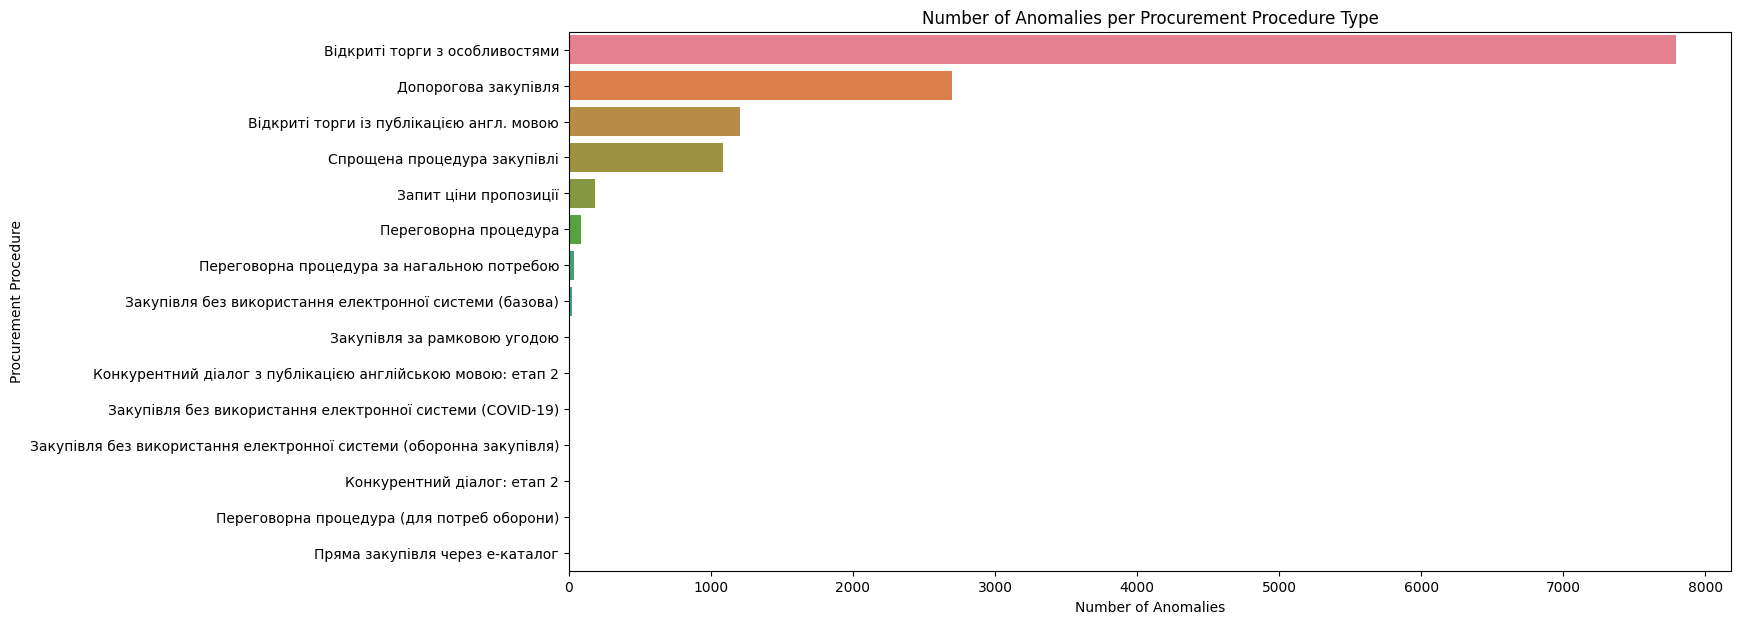

In [ ]:
plt.figure(figsize=(15, 7))
sns.barplot(
    data=procurement_summary.reset_index(),
    x='sum',
    y='procedure_type',
    hue='procedure_type',
    palette='husl',
    legend=False
)
plt.title("Number of Anomalies per Procurement Procedure Type")
plt.xlabel("Number of Anomalies")
plt.ylabel("Procurement Procedure")
plt.show()

## DBSCAN

DBSCAN is a clustering method that is used in machine learning to separate clusters of high density from clusters of low density region. Its a very efficient clustering algorithm as it used to segregate the data points with high density observations vs data points of low density observations in form of various clusters.

In [20]:
sweep_config = {
    'method': 'bayes', # works best among 'random' and 'grid'
    'metric': {
        'name': 'val_silhouette_score',
        'goal': 'maximize'
    },
    'parameters': {
        'eps': {'min': 0.2, 'max': 3.0},
        'min_samples': {'min': 3, 'max': 30}
    }
}


We tuned the hyper-parameters for DBSCAN using wandb and only part of the data - 10000 samples for validation and 50000 for training

In [6]:
def sweep_dbscan():
    wandb.init()
    config = wandb.config

    dbscan = DBSCAN(eps=config.eps, min_samples=config.min_samples)

    # Fit on training data
    dbscan.fit(train_prepared[final_cols])
    # Predict on validation data
    val_labels = dbscan.fit_predict(val_prepared[final_cols])

    mask = val_labels != -1
    if len(set(val_labels[mask])) > 1:
        score = silhouette_score(val_prepared[final_cols][mask], val_labels[mask])
    else:
        score = -1  # invalid clustering

    wandb.log({
        'val_silhouette_score': score,
        'num_clusters': len(set(val_labels)) - (1 if -1 in val_labels else 0)
    })

In [7]:
sweep_id = wandb.sweep(sweep_config, project="dbscan-fine-tuning")
wandb.agent(sweep_id, function=sweep_dbscan, count=15)

Create sweep with ID: h8dtvl5v
Sweep URL: https://wandb.ai/khrystyna-mysak-ukrainian-catholic-university/dbscan-fine-tuning/sweeps/h8dtvl5v


wandb: Agent Starting Run: xokl22fy with config:
wandb: 	eps: 0.8323182145776515
wandb: 	min_samples: 22
wandb: Currently logged in as: khrystyna-mysak (khrystyna-mysak-ukrainian-catholic-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


num_clusters,▁
val_silhouette_score,▁
num_clusters,40
val_silhouette_score,0.97493


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 3x10rfql with config:
wandb: 	eps: 2.6878826141618535
wandb: 	min_samples: 16


num_clusters,▁
val_silhouette_score,▁
num_clusters,3
val_silhouette_score,0.68361


wandb: Agent Starting Run: bjuiiiv9 with config:
wandb: 	eps: 1.4026638137993368
wandb: 	min_samples: 29


num_clusters,▁
val_silhouette_score,▁
num_clusters,10
val_silhouette_score,0.39654


wandb: Agent Starting Run: 5n813med with config:
wandb: 	eps: 1.0222049038599732
wandb: 	min_samples: 4


num_clusters,▁
val_silhouette_score,▁
num_clusters,58
val_silhouette_score,0.50478


wandb: Agent Starting Run: aq15ezxq with config:
wandb: 	eps: 1.291283635828944
wandb: 	min_samples: 26


num_clusters,▁
val_silhouette_score,▁
num_clusters,14
val_silhouette_score,0.5028


wandb: Agent Starting Run: melrsbk5 with config:
wandb: 	eps: 0.7196771275149749
wandb: 	min_samples: 23


num_clusters,▁
val_silhouette_score,▁
num_clusters,39
val_silhouette_score,0.97542


wandb: Agent Starting Run: ldggt362 with config:
wandb: 	eps: 0.5590132821290112
wandb: 	min_samples: 21


num_clusters,▁
val_silhouette_score,▁
num_clusters,44
val_silhouette_score,0.97661


wandb: Agent Starting Run: ga615t8s with config:
wandb: 	eps: 0.7619873652303397
wandb: 	min_samples: 20


num_clusters,▁
val_silhouette_score,▁
num_clusters,45
val_silhouette_score,0.97528


wandb: Agent Starting Run: 8q9xa5it with config:
wandb: 	eps: 0.20045513588465616
wandb: 	min_samples: 26


num_clusters,▁
val_silhouette_score,▁
num_clusters,34
val_silhouette_score,0.98045


wandb: Agent Starting Run: 6soe1m1h with config:
wandb: 	eps: 0.2421870831852242
wandb: 	min_samples: 24


num_clusters,▁
val_silhouette_score,▁
num_clusters,37
val_silhouette_score,0.97974


wandb: Agent Starting Run: x43h2vjf with config:
wandb: 	eps: 0.20979196454101431
wandb: 	min_samples: 19


num_clusters,▁
val_silhouette_score,▁
num_clusters,46
val_silhouette_score,0.97979


wandb: Agent Starting Run: 8sft1iky with config:
wandb: 	eps: 0.213037613739876
wandb: 	min_samples: 15


num_clusters,▁
val_silhouette_score,▁
num_clusters,52
val_silhouette_score,0.97944


wandb: Agent Starting Run: lntns21v with config:
wandb: 	eps: 0.3738925299936999
wandb: 	min_samples: 17


num_clusters,▁
val_silhouette_score,▁
num_clusters,49
val_silhouette_score,0.97761


wandb: Agent Starting Run: k23trmu7 with config:
wandb: 	eps: 0.2159576285900993
wandb: 	min_samples: 18


num_clusters,▁
val_silhouette_score,▁
num_clusters,48
val_silhouette_score,0.97968


wandb: Agent Starting Run: w8b4xs6t with config:
wandb: 	eps: 2.94603350853889
wandb: 	min_samples: 4


num_clusters,▁
val_silhouette_score,▁
num_clusters,5
val_silhouette_score,0.69149


Trained DBSCAN on a small portion of train data and used fit_predict for the whole test dataset.

In [6]:
best_eps = 0.20046
best_min_samples = 26
final_dbscan = DBSCAN(min_samples=best_min_samples, eps=best_eps)

# Fit on train
final_dbscan.fit(train_prepared_part[final_cols])

# Fit Predict on test set
test_labels = final_dbscan.fit_predict(test_prepared[final_cols])
test_prepared['DBSCAN_Cluster'] = test_labels
test_prepared['Anomaly'] = test_labels == -1

### Results analysis

In [7]:
anomalies = test_prepared[test_prepared['Anomaly'] == True]

In [29]:
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(test_prepared[final_cols])

test_prepared['TSNE1'] = X_tsne[:, 0]
test_prepared['TSNE2'] = X_tsne[:, 1]

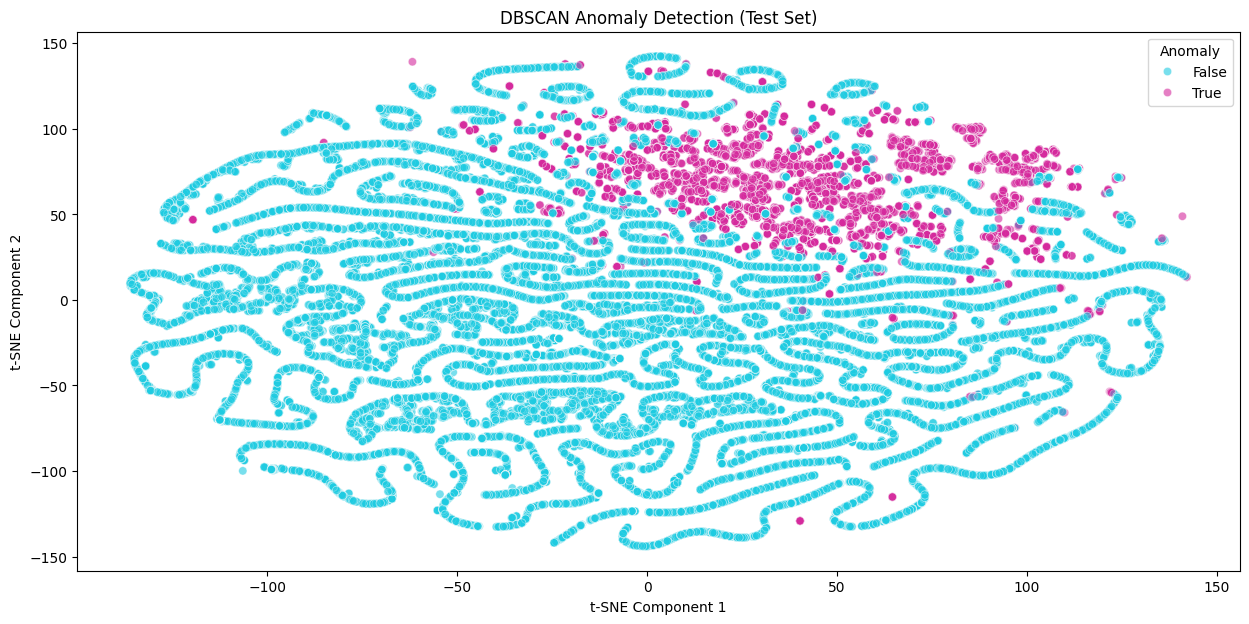

In [31]:
plt.figure(figsize=(15, 7))
sns.scatterplot(data=test_prepared, x='TSNE1', y='TSNE2', hue='Anomaly',
                palette={True: '#d52a9d', False: '#1ecbe1'}, alpha=0.6)
plt.title("DBSCAN Anomaly Detection (Test Set)")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend(title="Anomaly")
plt.show()

In [11]:
mask = test_prepared['DBSCAN_Cluster'] != -1  # Filter out noise points
if len(set(test_prepared['DBSCAN_Cluster'][mask])) > 1:  # Check if there are multiple clusters
    score = silhouette_score(test_prepared[final_cols][mask], test_prepared['DBSCAN_Cluster'][mask])
else:
    score = -1
print(f"Silhouette Score (for non-noise points): {score:.3f}")

Silhouette Score (for non-noise points): 0.975


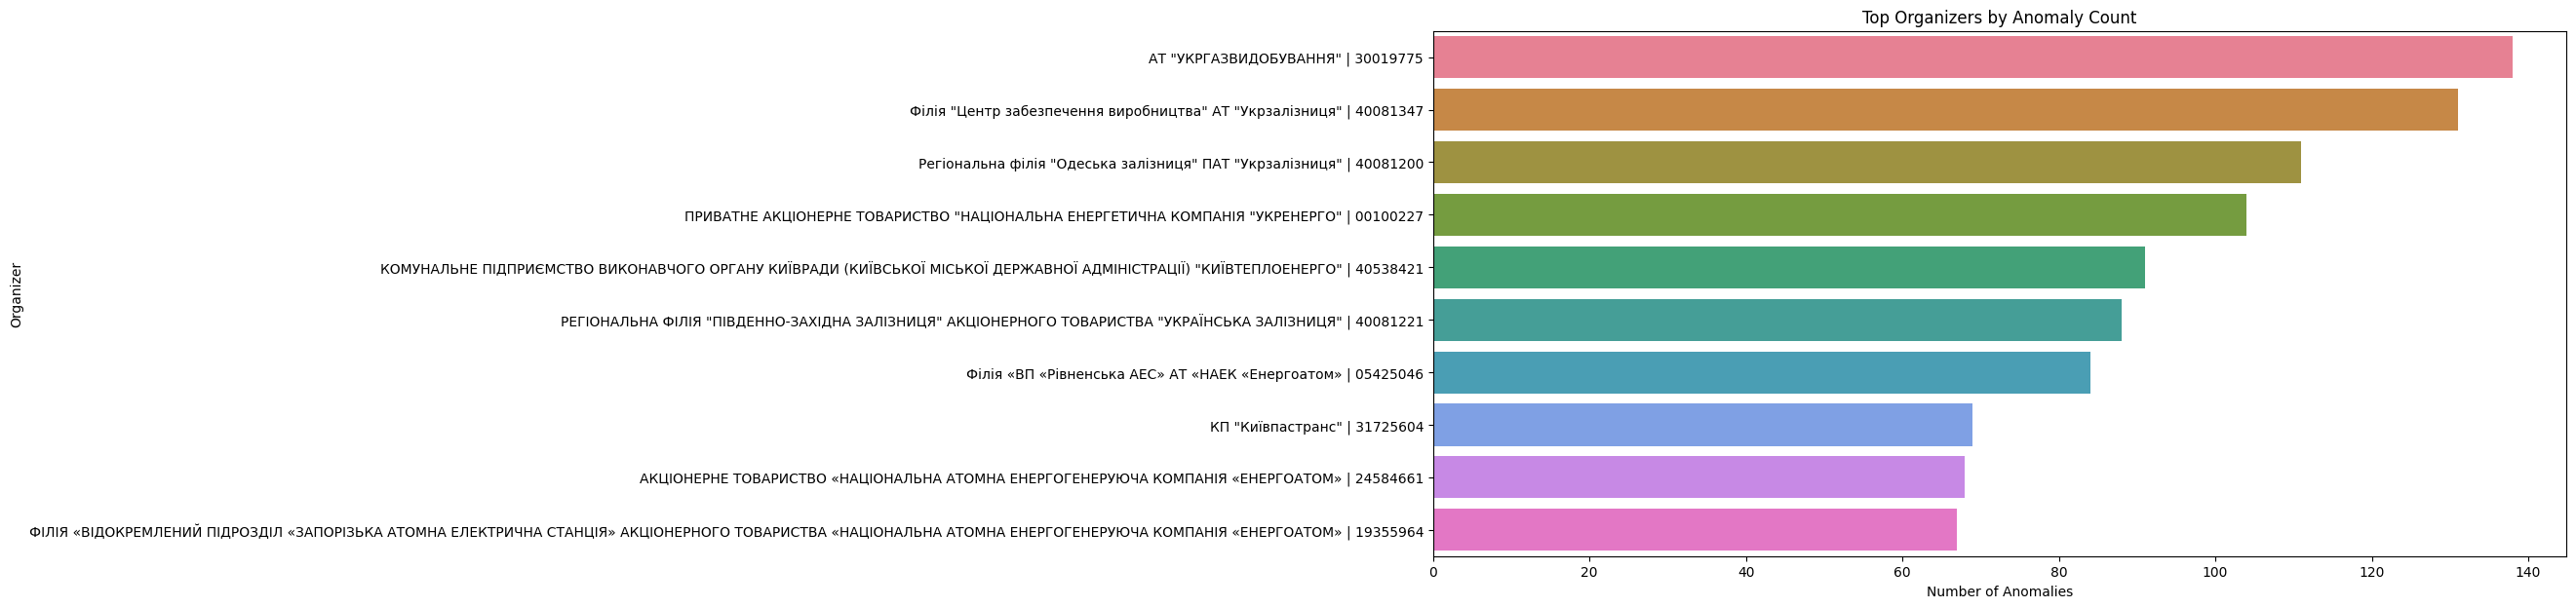

In [8]:
top_orgs = anomalies['organizer'].value_counts().nlargest(10)
top_orgs_df = top_orgs.reset_index()
top_orgs_df.columns = ['Organizer', 'Anomaly Count']

plt.figure(figsize=(15, 7))
sns.barplot(data=top_orgs_df, x='Anomaly Count', y='Organizer',
            hue='Organizer', palette='husl', legend=False)
plt.title("Top Organizers by Anomaly Count")
plt.xlabel("Number of Anomalies")
plt.ylabel("Organizer")
plt.show()

In [9]:
procurement_cols = [col for col in test_prepared.columns if col.startswith('procurement_procedure_')]

test_prepared['procedure_type'] = test_prepared[procurement_cols].idxmax(axis=1)
test_prepared['procedure_type'] = test_prepared['procedure_type'].str.replace('procurement_procedure_', '', regex=False)

procurement_summary = test_prepared.groupby('procedure_type')['Anomaly'].agg(['count', 'sum'])
procurement_summary['anomaly_ratio'] = procurement_summary['sum'] / procurement_summary['count']
procurement_summary = procurement_summary.sort_values('sum', ascending=False)

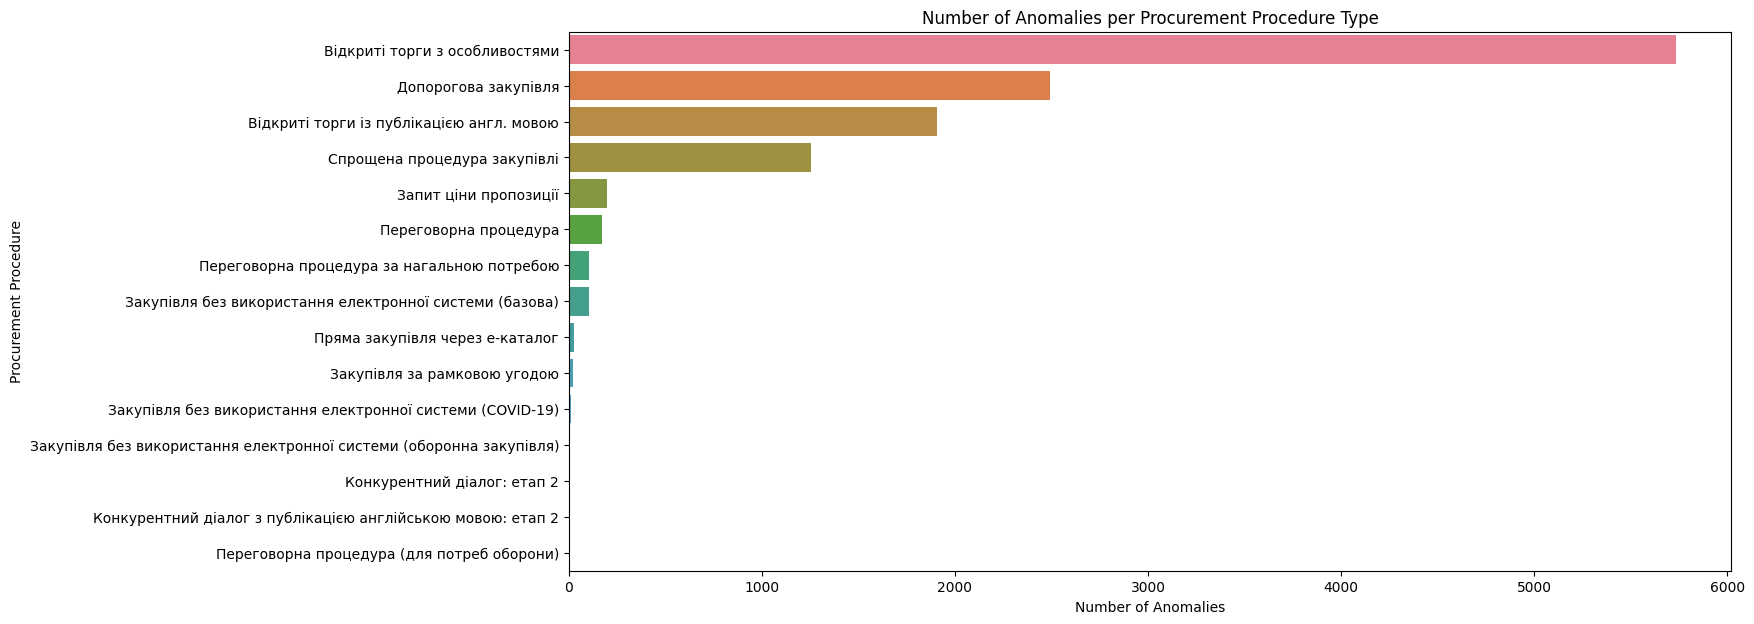

In [10]:
plt.figure(figsize=(15, 7))
sns.barplot(
    data=procurement_summary.reset_index(),
    x='sum',
    y='procedure_type',
    hue='procedure_type',
    palette='husl',
    legend=False
)
plt.title("Number of Anomalies per Procurement Procedure Type")
plt.xlabel("Number of Anomalies")
plt.ylabel("Procurement Procedure")
plt.show()

***Silhouette score***

- It ranges from -1 to +1:

- Positive values indicate that data points belong to the correct clusters, indicating good clustering results.
- A score of zero suggests overlapping clusters or data points equally close to multiple clusters.
- Negative values indicate that data points are assigned to incorrect clusters, indicating poor clustering results.

## Testing labelled

In [ ]:
labelled = pd.read_csv("/content/drive/MyDrive/ml_project/prozorro_labelled.csv")
labelled.columns = [
    "tender_id", "tender_url", "tender_title", "procurement_method",
    "expected_value", "tender_status", "organizer", "monitoring_id",
    "monitoring_start_date", "violation_correction_status", "detected_violations",
    "tender_announcement_date"
]
labelled.head()

,Ідентифікатор тендера,...,Заголовки тендерів,Тип методу закупівлі,Очікувана вартість тендера,Статус тендера,Організатор,Ідентифікатор моніторингу,Дата початку моніторингу органом моніторингу,Статус усунення порушень замовником (загалом),"Є порушення, виявлені органом моніторингу",Дата оголошення тендера
0,UA-2024-07-26-006577-a,https://prozorro.gov.ua/tender/UA-2024-07-26-0...,Капітальний ремонт будівлі Стовп’язької загаль...,Відкриті торги з особливостями,43139872.0,Завершена закупівля,"Відділ освіти, культури, туризму, молоді та сп...",UA-M-2025-02-18-000074,2025-02-18,-,0,2024-07-26
1,UA-2024-08-15-001731-a,https://prozorro.gov.ua/tender/UA-2024-08-15-0...,Сміттєвоз бокового завантаження на шасі JАC N2...,Відкриті торги з особливостями,5468835.0,Завершена закупівля,"Комунальне підприємство ""Комунальник"" | 32572536",UA-M-2025-02-18-000045,2025-02-18,-,0,2024-08-15
2,UA-2024-09-23-014147-a,https://prozorro.gov.ua/tender/UA-2024-09-23-0...,Реконструкція приміщень харчоблоку та будівлі ...,Відкриті торги з особливостями,11935780.0,Завершена закупівля,ДЕПАРТАМЕНТ ГУМАНІТАРНОЇ ПОЛІТИКИ ДНІПРОВСЬКОЇ...,UA-M-2025-02-18-000017,2025-02-18,-,0,2024-09-23
3,UA-2024-09-24-007689-a,https://prozorro.gov.ua/tender/UA-2024-09-24-0...,Реконструкція приміщень харчоблоку та будівлі ...,Відкриті торги з особливостями,12562969.2,Завершена закупівля,ДЕПАРТАМЕНТ ГУМАНІТАРНОЇ ПОЛІТИКИ ДНІПРОВСЬКОЇ...,UA-M-2025-02-18-000009,2025-02-18,-,0,2024-09-24
4,UA-2024-09-24-008834-a,https://prozorro.gov.ua/tender/UA-2024-09-24-0...,Реконструкція приміщень харчоблоку та будівлі ...,Відкриті торги з особливостями,14063182.8,Завершена закупівля,ДЕПАРТАМЕНТ ГУМАНІТАРНОЇ ПОЛІТИКИ ДНІПРОВСЬКОЇ...,UA-M-2025-02-18-000038,2025-02-18,-,0,2024-09-24


In [ ]:
url = labelled.iloc[0]['tender_url']
url

'https://prozorro.gov.ua/tender/UA-2024-07-26-006577-a'

In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import re
from tqdm import tqdm
import concurrent.futures

def get_actual_tender_uuid(public_id):
    """
    Given a public tender ID (e.g., 'UA-2025-04-29-000001'),
    fetch and extract the actual UUID from the Prozorro tender page.
    """
    url = f"https://prozorro.gov.ua/tender/{public_id}"
    try:
        response = requests.get(url, timeout=10)
        response.raise_for_status()
        soup = BeautifulSoup(response.text, 'html.parser')
        for a_tag in soup.find_all('a', attrs={'data-url': True}):
            data_url = a_tag['data-url']
            # Match the UUID pattern in the 'data-url' attribute
            match = re.search(r'/tender/[^/]+/print/awards/pdf/([a-f0-9]{32})', data_url)
            if match:
                return match.group(1)
    except Exception as e:
        print(f"Error fetching UUID for {public_id}: {e}")
    return None

def get_tender_details(tender_uuid):
    """
    Given a tender UUID, fetch detailed information from the Prozorro API.
    """
    url = f"https://public.api.openprocurement.org/api/2.5/tenders/{tender_uuid}"
    try:
        response = requests.get(url, timeout=10)
        response.raise_for_status()
        return response.json().get("data", {})
    except Exception as e:
        print(f"Error fetching details for UUID {tender_uuid}: {e}")
    return {}

def extract_properties(tender_data):
    """
    Extract desired properties from the tender data.
    """
    return {
        'price_per_unit': tender_data.get('value', {}).get('amount'),
        'number_of_participants': len(tender_data.get('bids', [])),
        'number_of_disqualifications': sum(1 for bid in tender_data.get('bids', []) if bid.get('status') == 'unsuccessful'),
        'number_of_questions': len(tender_data.get('questions', [])),
        'number_of_requirements': len(tender_data.get('requirements', [])),
        'number_of_complaints': len(tender_data.get('complaints', [])),
        'number_of_monitorings': len(tender_data.get('monitorings', []))
    }

def fetch_uuid_for_tender(public_id):
    """
    Fetch the UUID for a given tender and return it.
    """
    uuid = get_actual_tender_uuid(public_id)
    return (public_id, uuid)

def process_tender_details(tender_uuid):
    """
    Fetch tender details for a given UUID and extract properties.
    """
    if tender_uuid:
        tender_data = get_tender_details(tender_uuid)
        if tender_data:
            properties = extract_properties(tender_data)
            return properties
    return None

# Step 1: Fetch UUIDs for all tenders
def fetch_uuids(labelled):
    """
    Fetch UUIDs for all tenders in parallel.
    """
    with concurrent.futures.ThreadPoolExecutor(max_workers=10) as executor:
        futures = {executor.submit(fetch_uuid_for_tender, public_id): public_id for public_id in labelled['tender_id']}
        for future in tqdm(concurrent.futures.as_completed(futures), total=len(futures), desc="Fetching UUIDs"):
            public_id, uuid = future.result()
            if uuid:
                labelled.at[labelled[labelled['tender_id'] == public_id].index[0], 'uuid'] = uuid
            else:
                print(f"UUID not found for tender ID {public_id}")

# Step 2: Fetch tender details using the fetched UUIDs
def fetch_tender_details(labelled):
    """
    Fetch tender details in parallel for all tenders with UUIDs.
    """
    results = []
    with concurrent.futures.ThreadPoolExecutor(max_workers=10) as executor:
        futures = {executor.submit(process_tender_details, tender_uuid): tender_uuid for tender_uuid in labelled['uuid'] if pd.notnull(tender_uuid)}
        for future in tqdm(concurrent.futures.as_completed(futures), total=len(futures), desc="Fetching tender details"):
            properties = future.result()
            if properties:
                public_id = labelled[labelled['uuid'] == future.result()].iloc[0]['tender_id']
                idx = labelled[labelled['tender_id'] == public_id].index[0]
                for key, value in properties.items():
                    labelled.at[idx, key] = value


part_100 = labelled[:100]
part_100['uuid'] = None
fetch_uuids(part_100)
fetch_tender_details(part_100)
part_100


<ipython-input-106-c13b994593c9>:105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  part_100['uuid'] = None
Fetching UUIDs: 100%|██████████| 100/100 [00:48<00:00,  2.07it/s]


,tender_id,tender_url,tender_title,procurement_method,expected_value,tender_status,organizer,monitoring_id,monitoring_start_date,violation_correction_status,detected_violations,tender_announcement_date,uuid
0,UA-2024-07-26-006577-a,https://prozorro.gov.ua/tender/UA-2024-07-26-0...,Капітальний ремонт будівлі Стовп’язької загаль...,Відкриті торги з особливостями,43139872.00,Завершена закупівля,"Відділ освіти, культури, туризму, молоді та сп...",UA-M-2025-02-18-000074,2025-02-18,-,0,2024-07-26,ee4787b1ff61447f8a9e3f8c5215df84
1,UA-2024-08-15-001731-a,https://prozorro.gov.ua/tender/UA-2024-08-15-0...,Сміттєвоз бокового завантаження на шасі JАC N2...,Відкриті торги з особливостями,5468835.00,Завершена закупівля,"Комунальне підприємство ""Комунальник"" | 32572536",UA-M-2025-02-18-000045,2025-02-18,-,0,2024-08-15,4323bb4c5bd844c192537a1394ecac79
2,UA-2024-09-23-014147-a,https://prozorro.gov.ua/tender/UA-2024-09-23-0...,Реконструкція приміщень харчоблоку та будівлі ...,Відкриті торги з особливостями,11935780.00,Завершена закупівля,ДЕПАРТАМЕНТ ГУМАНІТАРНОЇ ПОЛІТИКИ ДНІПРОВСЬКОЇ...,UA-M-2025-02-18-000017,2025-02-18,-,0,2024-09-23,fc4fd4c069ce4b049d09bcf920780bc4
3,UA-2024-09-24-007689-a,https://prozorro.gov.ua/tender/UA-2024-09-24-0...,Реконструкція приміщень харчоблоку та будівлі ...,Відкриті торги з особливостями,12562969.20,Завершена закупівля,ДЕПАРТАМЕНТ ГУМАНІТАРНОЇ ПОЛІТИКИ ДНІПРОВСЬКОЇ...,UA-M-2025-02-18-000009,2025-02-18,-,0,2024-09-24,b85ab82ce37742dc9e75d24e594ca41a
4,UA-2024-09-24-008834-a,https://prozorro.gov.ua/tender/UA-2024-09-24-0...,Реконструкція приміщень харчоблоку та будівлі ...,Відкриті торги з особливостями,14063182.80,Завершена закупівля,ДЕПАРТАМЕНТ ГУМАНІТАРНОЇ ПОЛІТИКИ ДНІПРОВСЬКОЇ...,UA-M-2025-02-18-000038,2025-02-18,-,0,2024-09-24,93cd134ec83447a190dae18188dd5f31
...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,UA-2024-12-27-009651-a,https://prozorro.gov.ua/tender/UA-2024-12-27-0...,«Нове будівництво ПРУ на території Гімназії №...,Закупівля без використання електронної системи...,1642793.54,Завершена закупівля,Гімназія № 6 Звягельської міської ради | 22060221,UA-M-2025-02-17-000041,2025-02-17,-,0,2024-12-27,d4f2442d6b7742a280d251122c3ab90e
96,UA-2024-12-27-011784-a,https://prozorro.gov.ua/tender/UA-2024-12-27-0...,Капітальний ремонт харчоблоку(з облаштуванням ...,Закупівля без використання електронної системи...,1134262.18,Завершена закупівля,ЛІЦЕЙ №1 ІМЕНІ ЛЕСІ УКРАЇНКИ ЗВЯГЕЛЬСЬКОЇ МІСЬ...,UA-M-2025-02-17-000040,2025-02-17,-,0,2024-12-27,2f2d2a65c211408995a75b45817dec6e
97,UA-2024-12-27-012889-a,https://prozorro.gov.ua/tender/UA-2024-12-27-0...,Капітальний ремонт орендованих нежитлових прим...,Відкриті торги з особливостями,4286387.00,Завершена закупівля,"Департамент спорту, сім'ї та молоді Запорізько...",UA-M-2025-02-17-000056,2025-02-17,-,0,2024-12-27,cdbbe64c2f02403ba5cd62b67b64f359
98,UA-2025-01-07-004180-a,https://prozorro.gov.ua/tender/UA-2025-01-07-0...,Послуги з управління медичними відходами,Відкриті торги з особливостями,374000.00,Завершена закупівля,"КОМУНАЛЬНЕ НЕКОМЕРЦІЙНЕ ПІДПРИЄМСТВО ""МИРГОРОД...",UA-M-2025-02-17-000050,2025-02-17,-,0,2025-01-07,2e575682463a45a1bf95331bc83ba981
